In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
sys.path.insert(0, os.getenv('SRC_PATH'))

import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
from src.volsurface import GridInterpVolSurface, KernelVolSurface
from src.utils.data_helper import clean_data, VolSurfPointwiseDataset

import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from src.train import Trainer

import json

DB_PATH = os.getenv('DB_PATH')
CSV_PATH = os.getenv('CSV_PATH')
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('future.no_silent_downcasting', True)

/Users/zhanghq/miniconda3/envs/vae-volsurface/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-16 21:41:41,651	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-04-16 21:41:41,742	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
from src.utils.logger import setup_logger
logger = setup_logger('train')

In [ ]:
query = """
SELECT date, symbol, exdate, last_date, cp_flag, strike_price, best_bid, best_offer, volume, open_interest, impl_volatility, delta
FROM opprc
"""
dtype = {
    'symbol': 'string',
    'cp_flag': 'string',
    'strike_price': 'float64',
    'best_bid': 'float64',
    'best_offer': 'float64',
    'volume': 'int64',
    'open_interest': 'int64',
    'impl_volatility': 'float64',
    'delta': 'float64'
}
df_raw = pd.read_sql_query(query, conn, parse_dates=['date', 'exdate', 'last_date'])
df_raw = df_raw.replace('', np.nan) # sqlite returns empty strings for NULL values
df_raw = df_raw.astype(dtype)

df = clean_data(df_raw)

In [3]:
model_name = "vae_pw_improve"
train_model = True
load_model = False
save_model = False
data_dir = CSV_PATH + "/predicted_vol_surfaces.json"  # Path to the volatility surfaces dataset
batch_size = 32
epochs = 10

In [4]:
maturity_grid = np.array([1, 7, 30, 60, 90, 180, 360, 720])
delta_grid = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [5]:
SRC_PATH = os.getenv('SRC_PATH')
os.chdir(SRC_PATH)
trainer = Trainer(model_name)
trainer.create_model()

[2025-04-16 21:41:44] [INFO] src.train (61) : Using device: mps


In [7]:
with open(data_dir, "r") as f:
    data = json.load(f)

In [8]:
mapping_ids = {dt: i for i, dt in enumerate(sorted(map(lambda x: x[:10], data.keys())))}

In [9]:
df['mapping_ids'] = df['date'].dt.strftime('%Y-%m-%d').map(mapping_ids)

In [17]:
vol_surfaces = []
for key in sorted(data.keys()):
    surface = torch.tensor(data[key], dtype=torch.float32)
    vol_surfaces.append(surface.flatten())  # Flatten 2D to 1D

data_tensor = torch.stack(vol_surfaces)
pw_grid_data = torch.tensor(df[['ttm', 'moneyness']].values, dtype=torch.float32)
# !only for test run
pw_grid_data[:, 0] = pw_grid_data[:, 0] / 365.0
pw_vol_data = torch.tensor(df['impl_volatility'].values, dtype=torch.float32)
mapping_ids = torch.tensor(df['mapping_ids'].values).long()

assert data_tensor.shape[0] == max(mapping_ids) + 1

In [ ]:
dataset = VolSurfPointwiseDataset(pw_grid_data, pw_vol_data, data_tensor, mapping_ids)
train_loader = DataLoader(
    dataset, 
    batch_size=trainer.batch_size,
    shuffle=True
)

In [16]:
# Train the model
for epoch in range(epochs):
    logger.info(f"Epoch {epoch + 1}/{epochs}")
    trainer.train(train_loader)

[2025-04-16 19:08:49] [INFO] train (3) : Epoch 1/10
[2025-04-16 19:09:41] [INFO] src.train (180) : Loss: 0.0043
[2025-04-16 19:09:41] [INFO] train (3) : Epoch 2/10
[2025-04-16 19:10:35] [INFO] src.train (180) : Loss: 0.0036
[2025-04-16 19:10:35] [INFO] train (3) : Epoch 3/10
[2025-04-16 19:11:28] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:11:28] [INFO] train (3) : Epoch 4/10
[2025-04-16 19:12:21] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:12:21] [INFO] train (3) : Epoch 5/10
[2025-04-16 19:13:13] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:13:13] [INFO] train (3) : Epoch 6/10
[2025-04-16 19:14:05] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:14:05] [INFO] train (3) : Epoch 7/10
[2025-04-16 19:14:58] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:14:58] [INFO] train (3) : Epoch 8/10
[2025-04-16 19:15:52] [INFO] src.train (180) : Loss: 0.0035
[2025-04-16 19:15:52] [INFO] train (3) : Epoch 9/10
[2025-04-16 19:16:45] [INFO] src.train (180) : Loss:

In [22]:
torch.save(trainer.model.state_dict(), f"params/{trainer.model_name}.pth")

## Test generation

In [6]:
from src.volsurface import TrainedDecoderVolSurface

In [7]:
trainer.load_model("params/vae_pw_improve.pth")

[2025-04-16 21:41:47] [INFO] src.train (137) : Model loaded from params/vae_pw_improve.pth


In [8]:
def normal_rng(shape, mean=0.0, std=1.0):
    rng = np.random.default_rng(seed=42)
    while True:
        yield rng.normal(loc=mean, scale=std, size=shape)

test_rng = normal_rng(4)

In [22]:
tdvs = TrainedDecoderVolSurface(
    decoder=trainer.model.decoder,
    maturity_range=(min(maturity_grid), 180.0),
    random_src=test_rng
)

In [23]:
tdvs.predict_grid(delta_grid, maturity_grid)

array([[0.18798843, 0.17004122, 0.15584353, 0.16071936, 0.16510709,
        0.17884663, 0.36642337, 1.        ],
       [0.17538862, 0.16017632, 0.15317523, 0.15832181, 0.1636079 ,
        0.1803179 , 0.41276214, 1.        ],
       [0.16527288, 0.15077755, 0.15054445, 0.15561889, 0.16083196,
        0.17916754, 0.44165072, 1.        ],
       [0.15563047, 0.14474231, 0.14795099, 0.15295373, 0.15809606,
        0.1796371 , 0.4583497 , 1.        ],
       [0.14681666, 0.14189045, 0.14539455, 0.15180783, 0.15852106,
        0.18118326, 0.47039074, 1.        ],
       [0.14410359, 0.14391036, 0.14814122, 0.15360883, 0.1577395 ,
        0.18135257, 0.48246604, 1.        ],
       [0.14484604, 0.14509258, 0.14661887, 0.15059501, 0.15495221,
        0.18264435, 0.49456176, 1.        ],
       [0.14486535, 0.1451119 , 0.14606029, 0.14957112, 0.15815043,
        0.18628816, 0.5092566 , 1.        ],
       [0.14488465, 0.1453806 , 0.14966418, 0.15540713, 0.1614021 ,
        0.1899878 , 0.529239

<Axes3D: title={'center': 'Volatility Surface'}, xlabel='Delta', ylabel='Maturity', zlabel='Implied Volatility'>

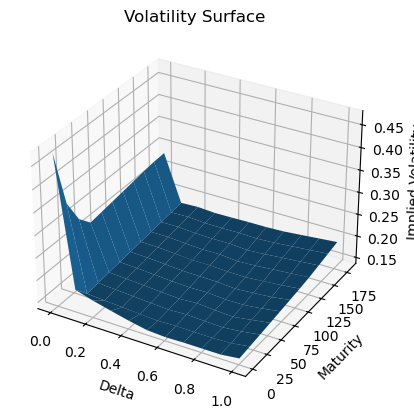

In [57]:
tdvs.refresh()
tdvs.plot()